## Import Useful Libraries

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling3D, Dropout, TimeDistributed, Flatten, Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

## Functions for preprocessing and Train Test Cases

In [2]:
def count_images_per_class(input_path):
    class_counts = {}
    for class_dir in os.listdir(input_path):
        count = len(os.listdir(os.path.join(input_path, class_dir)))
        class_counts[class_dir] = count
        print(f"{class_dir} has {count} number of images")
    return class_counts

def preprocess_data(input_path, top_emotions):
    data = defaultdict(str)
    for dir_ in os.listdir(input_path):
        if dir_ in top_emotions:
            data[dir_] = defaultdict(list)
            for f in os.listdir(os.path.join(input_path, dir_)):
                sub = f.split("_")[0]
                data[dir_][sub].append(f)

    return data

def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def ImageToArray(x, path):
    arr = np.empty(shape=(3, 48, 48))
    for i, f in enumerate(x):
        img = cv2.imread(os.path.join(path, f), 0)
        arr[i] = img
    return arr

def create_dataset(data, data_path, labels):
    for emotion in data:
        data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
        data[emotion] = dict((k, ImageToArray(v, path=os.path.join(data_path, emotion))) for k, v in data[emotion].items())

    X, y = [], []
    for k, v in data.items():
        print(f"{k} has {len(v)} samples")
        stacked_data = np.stack(list(v.values()), axis=0)
        stacked_data = stacked_data.reshape(*stacked_data.shape, 1)
        X.append(stacked_data)
        y.append(np.array([labels.index(k)] * len(v)))

    X = np.concatenate(X)
    y = np.concatenate(y)
    y = np_utils.to_categorical(y)

    return X, y

def train_test_split_data(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True, random_state=42)
    return X_train, X_valid, y_train, y_valid

def display_sample_images(X_train, label_emotion_mapper, y_train, labels):
    np.random.seed(42)
    sample_indices = [np.random.choice(np.where(y_train[:, i] == 1)[0], size=1)[0] for i in range(len(labels))]

    fig = pyplot.figure(1, (6, 13))
    i = 0
    for name, idx in zip(label_emotion_mapper.values(), sample_indices):
        for j in range(3):
            i += 1
            ax = pyplot.subplot(5, 3, i)
            sample_img = X_train[idx, j, :, :, 0]
            ax.imshow(sample_img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(name)
    pyplot.show()
    
# Function to display images with actual and predicted labels
def display_images_with_labels(images, actual_labels, predicted_labels, label_emotion_mapper):
    num_images = len(images)
    num_cols = min(2, num_images)  # Set the number of columns to a maximum of 2
    num_rows = (num_images + num_cols - 1) // num_cols

    pyplot.figure(figsize=(12, 15))
    for i in range(num_images):
        pyplot.subplot(num_rows, num_cols, i+1)
        pyplot.imshow(images[i], cmap='gray')
        pyplot.title(f'Actual: {label_emotion_mapper[actual_labels[i]]}\nPredicted: {label_emotion_mapper[predicted_labels[i]]}')
        pyplot.axis('off')
    pyplot.show()


## Reward Function to implement Reinforcement Learning

In [3]:
def get_reward(predictions, true_labels, action_penalty=-0.1, correct_reward=1.0):
    # Reward function: Penalize incorrect actions and reward correct actions
    rewards = np.where(np.argmax(predictions, axis=2) == np.argmax(true_labels, axis=2), correct_reward, action_penalty)
    return rewards

## LSTM Model

In [4]:
def build_conv_lstm_model(input_shape, num_classes):
    model = Sequential(name='ConvLSTM2D')
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, return_sequences=True,
                         recurrent_activation='hard_sigmoid', activation='tanh', padding='same',
                         kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.01), dropout=0.2,
                         recurrent_dropout=0.2, name='convlstm2d_1'))
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', name='maxpool3d_2'))
    model.add(Dropout(0.5, name='dropout_2'))
    model.add(TimeDistributed(Flatten(name="flatten")))
    model.add(Dropout(0.5, name='dropout_3'))
    model.add(TimeDistributed(Dense(64, activation='elu', kernel_initializer='he_normal',
                                    kernel_regularizer=l2(0.01), name='dense_1')))
    model.add(BatchNormalization(name='batchnorm_2'))
    model.add(Dropout(0.5, name="dropout_4"))
    model.add(TimeDistributed(Dense(num_classes, activation='softmax', name='out_layer')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], sample_weight_mode="temporal")


    return model

def train_conv_lstm_model(model, X_train, y_train_, X_valid, y_valid_, episodes, batch_size, action_penalty, correct_reward):
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for episode in range(episodes):
        history = model.fit(
            x=X_train,
            y=y_train_,
            validation_data=(X_valid, y_valid_),
            batch_size=batch_size,
            epochs=1,  # Training for one epoch at a time
            use_multiprocessing=True,
        )

        # Append accuracy and loss values to the lists
        train_accuracies.append(history.history['accuracy'][0])
        val_accuracies.append(history.history['val_accuracy'][0])
        train_losses.append(history.history['loss'][0])
        val_losses.append(history.history['val_loss'][0])

        val_predictions = model.predict(X_valid)

        # Get rewards
        rewards = get_reward(val_predictions, y_valid_, action_penalty=action_penalty, correct_reward=correct_reward)

        # Update model with rewards
        model.train_on_batch(X_valid, y_valid_, sample_weight=rewards)

        print(f"Episode {episode + 1}: Reward = {np.sum(rewards)} | Penalty = {np.sum(action_penalty * (1 - rewards))}")

    return model, train_accuracies, val_accuracies, train_losses, val_losses

## Loading the Data with Classes

In [5]:
DATA_PATH = "CK+48/"
Lables = ["happy", "surprise", "anger", "sadness", "fear"]

## Count of each Label and splitting the data for training and validation

In [6]:
class_counts = count_images_per_class(DATA_PATH)
data = preprocess_data(DATA_PATH, Lables)
X, y = create_dataset(data, DATA_PATH, Lables)
X_train, X_valid, y_train, y_valid = train_test_split_data(X, y)

anger has 135 number of images
fear has 75 number of images
happy has 207 number of images
sadness has 84 number of images
surprise has 249 number of images
anger has 45 samples
fear has 25 samples
happy has 69 samples
sadness has 28 samples
surprise has 83 samples


anger has 135 number of images
fear has 75 number of images
happy has 207 number of images
sadness has 84 number of images
surprise has 249 number of images
anger has 45 samples
fear has 25 samples
happy has 69 samples
sadness has 28 samples
surprise has 83 samples

## Displaying Sample data along with its class label

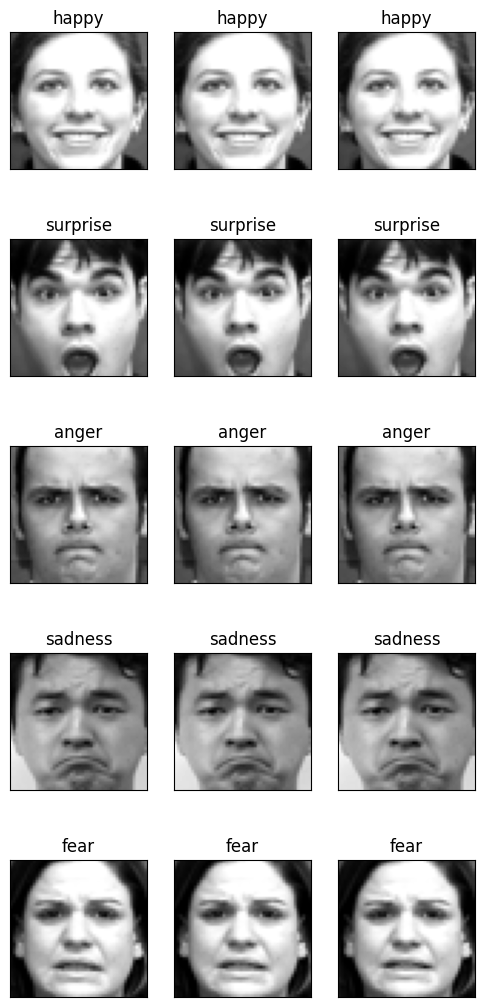

In [7]:
display_sample_images(X_train, {i: emotion for i, emotion in enumerate(Lables)}, y_train, Lables)

## Building and training the model using Reinforcement learning

In [8]:
INPUT_SHAPE = (3, 48, 48, 1)
NUM_CLASSES = len(Lables)

y_train_ = np.tile(y_train[:, np.newaxis, :], (1, 3, 1))
y_valid_ = np.tile(y_valid[:, np.newaxis, :], (1, 3, 1))

model = build_conv_lstm_model(INPUT_SHAPE, NUM_CLASSES)

# Train the model with reinforcement learning
model, train_accuracies, val_accuracies, train_losses, val_losses = train_conv_lstm_model(
    model,
    X_train,
    y_train_,
    X_valid,
    y_valid_,
    episodes=30,
    batch_size=8,
    action_penalty=-0.1,  # Penalty for incorrect actions
    correct_reward=1.0,   # Reward for correct actions
)


3/3 [==============================] - 2s 471ms/step
Episode 1: Reward = 106.20000000000002 | Penalty = -11.879999999999999
3/3 [==============================] - 2s 471ms/step
Episode 2: Reward = 90.80000000000001 | Penalty = -13.42
3/3 [==============================] - 2s 442ms/step
Episode 3: Reward = 140.3 | Penalty = -8.47
3/3 [==============================] - 2s 493ms/step
Episode 4: Reward = 144.70000000000002 | Penalty = -8.030000000000001
3/3 [==============================] - 2s 515ms/step
Episode 5: Reward = 128.20000000000002 | Penalty = -9.68
3/3 [==============================] - 2s 583ms/step
Episode 6: Reward = 122.70000000000002 | Penalty = -10.23
3/3 [==============================] - 2s 516ms/step
Episode 7: Reward = 177.7 | Penalty = -4.73
3/3 [==============================] - 2s 511ms/step
Episode 8: Reward = 181.0 | Penalty = -4.4
3/3 [==============================] - 2s 442ms/step
Episode 9: Reward = 178.8 | Penalty = -4.620000000000001
3/3 [=================

## Plotting accuracy and loss

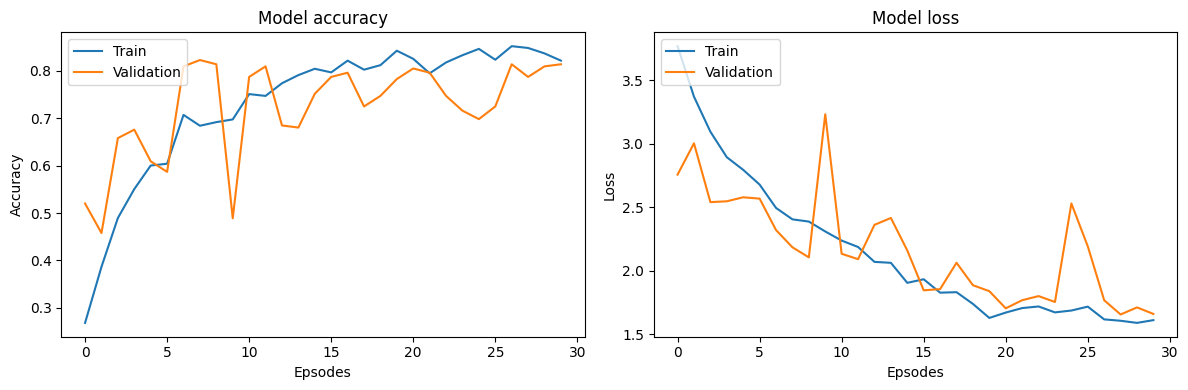

In [9]:
pyplot.figure(figsize=(12, 4))
# Plot training & validation accuracy values
pyplot.subplot(1, 2, 1)
pyplot.plot(train_accuracies)
pyplot.plot(val_accuracies)
pyplot.title('Model accuracy')
pyplot.xlabel('Epsodes')
pyplot.ylabel('Accuracy')
pyplot.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
pyplot.subplot(1, 2, 2)
pyplot.plot(train_losses)
pyplot.plot(val_losses)
pyplot.title('Model loss')
pyplot.xlabel('Epsodes')
pyplot.ylabel('Loss')
pyplot.legend(['Train', 'Validation'], loc='upper left')

pyplot.tight_layout()
pyplot.show()

## Confusion Matrix

3/3 [==============================] - 2s 501ms/step
          happy  surprise  anger  sadness  fear
happy        63         0      0        0     0
surprise      0        69      1        0     5
anger         0         2     34        1     2
sadness       0         6      3        6     9
fear          2         6      3        2    11


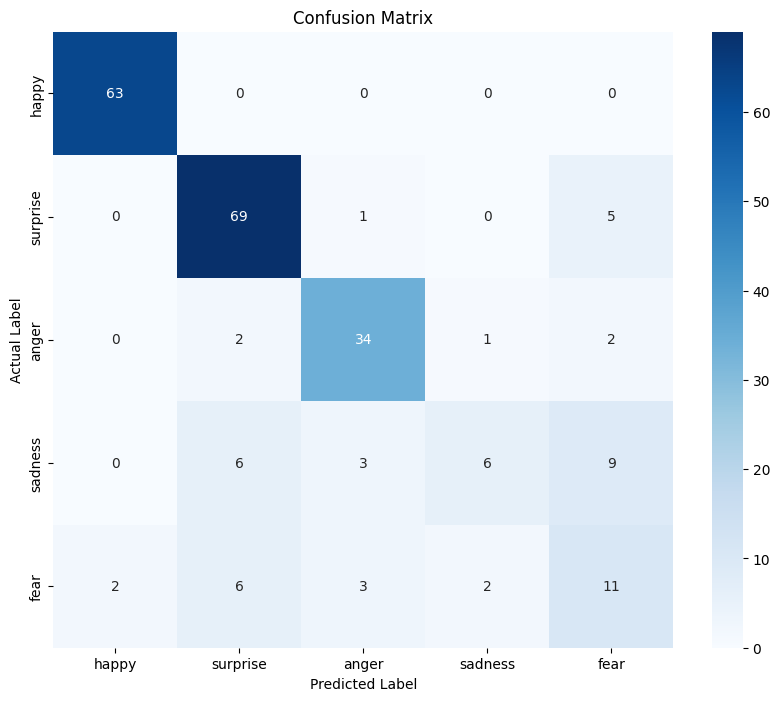

In [12]:
# Get predictions on the validation set
predictions = model.predict(X_valid)

# Convert one-hot encoded labels to categorical labels
predicted_labels = np.argmax(predictions, axis=2)
actual_labels = np.argmax(y_valid_, axis=2)

# Flatten the labels for classification report
actual_labels_flat = actual_labels.flatten()
predicted_labels_flat = predicted_labels.flatten()


# Generate a confusion matrix
cm = confusion_matrix(actual_labels_flat, predicted_labels_flat)


# Convert confusion matrix to a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=Lables, columns=Lables)
print(cm_df)
# Plot the heatmap
pyplot.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted Label')
pyplot.ylabel('Actual Label')
pyplot.show()

## Displaying Sample data along with its actual class and predicted class

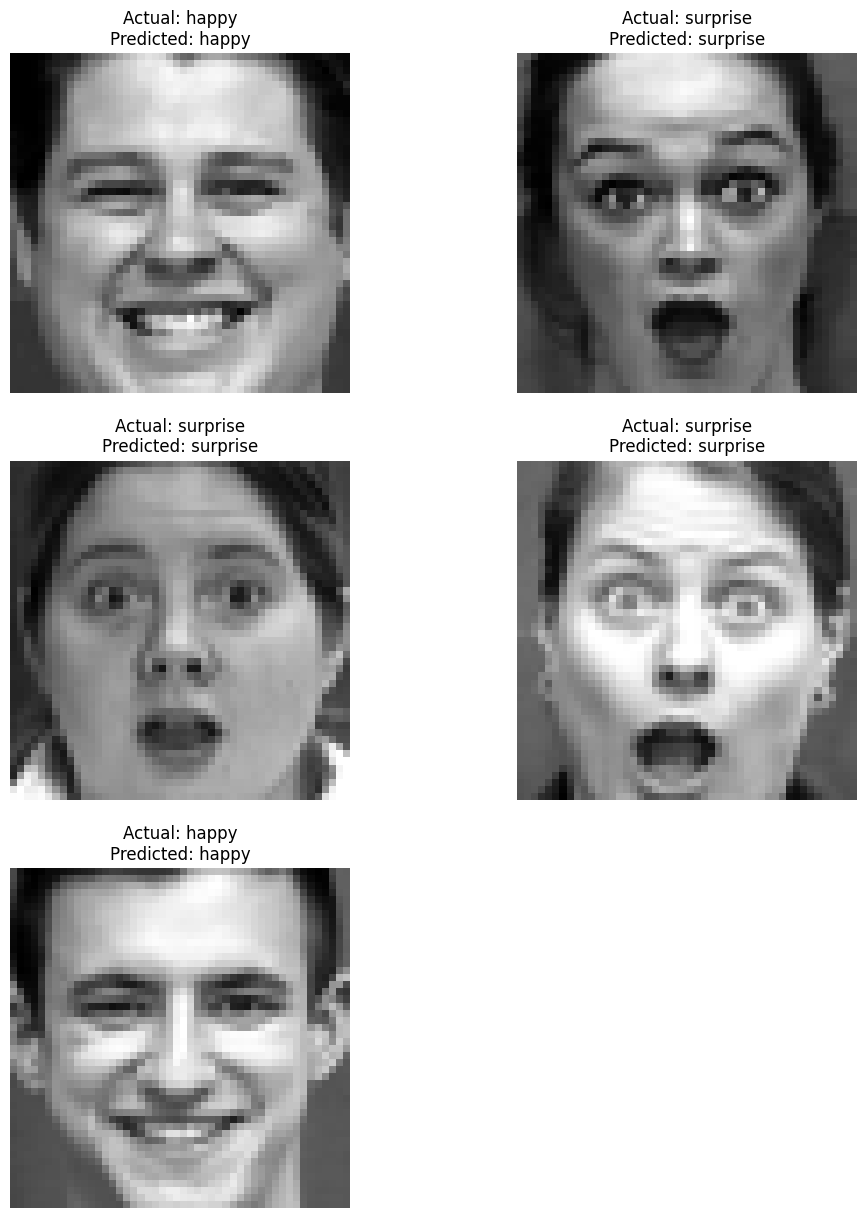

In [15]:
num_samples_to_display = 5
random_indices = random.sample(range(len(X_valid)), num_samples_to_display)
sample_images = X_valid[random_indices, 0, :, :, 0]
sample_actual_labels = np.argmax(y_valid_[random_indices, 0, :], axis=1)
sample_predicted_labels = predicted_labels[random_indices, 0]

# Display the images with actual and predicted labels
display_images_with_labels(sample_images, sample_actual_labels, sample_predicted_labels, {i: emotion for i, emotion in enumerate(Lables)})